## Install and import libraries

In [1]:
# Install jieba for Chinese text segmentation 
!pip install jieba --user

In [39]:
import os
import jieba
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
tf.enable_eager_execution()
warnings.filterwarnings('ignore')

## Load and preprocess lyrics

In [2]:
# Directory of lyrics
data_dir = os.path.join(os.path.dirname(os.getcwd()), 'data/lyrics')

In [3]:
# Read in lyrics
text_all = ''
for song in os.listdir(data_dir):
    if song.endswith('.txt'):
        text = open(os.path.join(data_dir, song), mode = 'rb').read().decode(encoding = "utf-8")
        text_all += text

In [4]:
# Use Jieba to segment lyrics into words
text_all = jieba.lcut(text_all)

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 1.058 seconds.
Prefix dict has been built successfully.


In [5]:
# Save a unique words into vocab
vocab = sorted(set(text_all))
print ('{} unique words'.format(len(vocab)))

3476 unique words


In [56]:
# Build word to index mapping
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text_all])

In [57]:
# Slice lyrics data into sequences
seq_length = 20
examples_per_epoch = len(text_all) // seq_length

char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

In [58]:
# Define inputs and outputs
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

sequences = char_dataset.batch(seq_length + 1, drop_remainder = True)
dataset = sequences.map(split_input_target)

In [59]:
# Shuffle the dataset
BUFFER_SIZE = 10000
dataset = dataset.shuffle(BUFFER_SIZE)

In [60]:
# Split into training and validation dataset
dataset_size = len(list(dataset))
train_size = int(0.8 * dataset_size)
valid_size = int(0.2 * dataset_size)

train_dataset = dataset.take(train_size)
valid_dataset = dataset.skip(train_size)

In [61]:
# Define batch size and batch training and validation dataset
BATCH_SIZE = 64
steps_per_epoch = examples_per_epoch // BATCH_SIZE
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder = True)
valid_dataset = valid_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder = True)

## Build models

In [62]:
# Define model parameters
vocab_size = len(vocab)
embedding_dim = 300
rnn_units = 1024
lstm_units = 1024

In [63]:
# Use GPU versions of RNN and LSTM layers 
rnn = tf.keras.layers.CuDNNGRU
lstm = tf.keras.layers.CuDNNLSTM

In [64]:
# Define LSTM model
def build_model_lstm(vocab_size, embedding_dim, lstm_units, batch_size):
    model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, 
        batch_input_shape = [batch_size, None]),
    lstm(lstm_units,
        return_sequences = True, 
        recurrent_initializer = 'glorot_uniform',
        stateful = True),
    lstm(lstm_units,
        return_sequences = True, 
        recurrent_initializer = 'glorot_uniform',
        stateful = True),
    tf.keras.layers.Dense(vocab_size)
    ])
    return model

In [65]:
# Define RNN model
def build_model_rnn(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, 
        batch_input_shape = [batch_size, None]),
    rnn(rnn_units,
        return_sequences = True, 
        recurrent_initializer = 'glorot_uniform',
        stateful = True),
    rnn(rnn_units,
        return_sequences = True, 
        recurrent_initializer = 'glorot_uniform',
        stateful = True),
    tf.keras.layers.Dense(vocab_size)
    ])
    return model

In [66]:
# Build RNN model
model_rnn = build_model_rnn(
    vocab_size = len(vocab), 
    embedding_dim = embedding_dim, 
    rnn_units = rnn_units, 
    batch_size = BATCH_SIZE)

In [67]:
# Build LSTM model
model_lstm = build_model_lstm(
    vocab_size = len(vocab),
    embedding_dim = embedding_dim, 
    lstm_units = lstm_units,
    batch_size = BATCH_SIZE)

In [68]:
# Define loss function
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits = True)

In [69]:
# Compile RNN model with loss and optimizer
model_rnn.compile(
    optimizer = tf.train.AdamOptimizer(),
    loss = loss)

In [70]:
# Compile LSTM model with loss and optimizer 
model_lstm.compile(
    optimizer = tf.train.AdamOptimizer(),
    loss = loss)

In [71]:
# Checkpoints for RNN model
checkpoint_dir_rnn = './Lyrics_training_rnn'

checkpoint_prefix_rnn = os.path.join(checkpoint_dir_rnn, "ckpt_{epoch}")

checkpoint_callback_rnn = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_prefix_rnn,
    save_weights_only = True)

In [72]:
# Checkpoints for LSTM model
checkpoint_dir_lstm = './Lyrics_training_lstm'

checkpoint_prefix_lstm = os.path.join(checkpoint_dir_lstm, "ckpt_{epoch}")

checkpoint_callback_lstm = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_prefix_lstm,
    save_weights_only = True)

## Train models

In [73]:
# Train RNN model
history = model_rnn.fit(train_dataset.repeat(), 
                    epochs = 30, 
                    steps_per_epoch = steps_per_epoch,
                    validation_data = valid_dataset,
                    callbacks = [checkpoint_callback_rnn]
                    )

Epoch 1/30
14/14 [==============================] - 3s 224ms/step - loss: 7.4448 - val_loss: 6.9262
Epoch 2/30
14/14 [==============================] - 1s 87ms/step - loss: 6.3607 - val_loss: 6.2267
Epoch 3/30
14/14 [==============================] - 1s 90ms/step - loss: 6.1394 - val_loss: 6.0256
Epoch 4/30
14/14 [==============================] - 1s 90ms/step - loss: 5.9974 - val_loss: 5.8308
Epoch 5/30
14/14 [==============================] - 1s 91ms/step - loss: 5.7844 - val_loss: 5.5659
Epoch 6/30
14/14 [==============================] - 1s 88ms/step - loss: 5.4933 - val_loss: 5.1941
Epoch 7/30
14/14 [==============================] - 1s 93ms/step - loss: 5.1190 - val_loss: 4.8176
Epoch 8/30
14/14 [==============================] - 1s 95ms/step - loss: 4.7353 - val_loss: 4.3091
Epoch 9/30
14/14 [==============================] - 1s 92ms/step - loss: 4.2745 - val_loss: 3.9105
Epoch 10/30
14/14 [==============================] - 1s 88ms/step - loss: 3.8631 - val_loss: 3.4499
Epoch 11

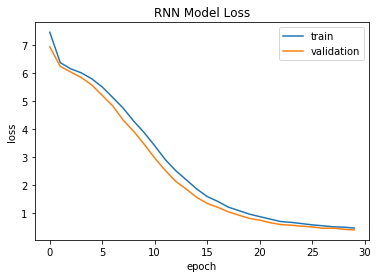

In [74]:
# Plot training and validation loss of RNN
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('RNN Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [75]:
# Train LSTM model
history = model_lstm.fit(train_dataset.repeat(), 
                    epochs = 50, 
                    steps_per_epoch = steps_per_epoch, 
                    validation_data = valid_dataset,
                    callbacks = [checkpoint_callback_lstm],
                    )

Epoch 1/50
14/14 [==============================] - 3s 235ms/step - loss: 6.7582 - val_loss: 6.4435
Epoch 2/50
14/14 [==============================] - 1s 96ms/step - loss: 6.1923 - val_loss: 6.1975
Epoch 3/50
14/14 [==============================] - 1s 94ms/step - loss: 6.1077 - val_loss: 6.0786
Epoch 4/50
14/14 [==============================] - 1s 107ms/step - loss: 6.0878 - val_loss: 6.0369
Epoch 5/50
14/14 [==============================] - 2s 114ms/step - loss: 6.0620 - val_loss: 5.9617
Epoch 6/50
14/14 [==============================] - 1s 93ms/step - loss: 5.8592 - val_loss: 5.7264
Epoch 7/50
14/14 [==============================] - 1s 100ms/step - loss: 5.6529 - val_loss: 5.5594
Epoch 8/50
14/14 [==============================] - 1s 107ms/step - loss: 5.4924 - val_loss: 5.3339
Epoch 9/50
14/14 [==============================] - 2s 116ms/step - loss: 5.2476 - val_loss: 5.1105
Epoch 10/50
14/14 [==============================] - 1s 99ms/step - loss: 5.0213 - val_loss: 4.8206
Epo

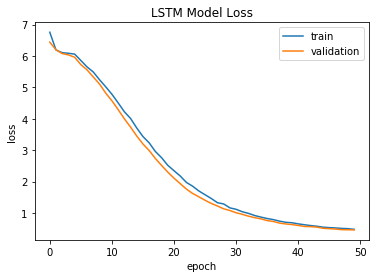

In [76]:
# Plot training and validation loss of LSTM
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [77]:
# Build RNN model using weights in the last checkpoint
model_rnn = build_model_rnn(vocab_size, embedding_dim, rnn_units, batch_size = 1)
model_rnn.load_weights(os.path.join(checkpoint_dir_rnn, 'ckpt_30'))
model_rnn.build(tf.TensorShape([1, None]))

In [78]:
# Build LSTM model using weights in the last checkpoint
model_lstm = build_model_lstm(vocab_size, embedding_dim, lstm_units, batch_size = 1)
model_lstm.load_weights(os.path.join(checkpoint_dir_lstm, 'ckpt_50'))
model_lstm.build(tf.TensorShape([1, None]))

In [79]:
# RNN model summmary
model_rnn.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (1, None, 300)            1042800   
_________________________________________________________________
cu_dnngru_6 (CuDNNGRU)       (1, None, 1024)           4073472   
_________________________________________________________________
cu_dnngru_7 (CuDNNGRU)       (1, None, 1024)           6297600   
_________________________________________________________________
dense_6 (Dense)              (1, None, 3476)           3562900   
Total params: 14,976,772
Trainable params: 14,976,772
Non-trainable params: 0
_________________________________________________________________


In [80]:
# LSTM model summary
model_lstm.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (1, None, 300)            1042800   
_________________________________________________________________
cu_dnnlstm_6 (CuDNNLSTM)     (1, None, 1024)           5431296   
_________________________________________________________________
cu_dnnlstm_7 (CuDNNLSTM)     (1, None, 1024)           8396800   
_________________________________________________________________
dense_7 (Dense)              (1, None, 3476)           3562900   
Total params: 18,433,796
Trainable params: 18,433,796
Non-trainable params: 0
_________________________________________________________________


## Generate lyrics

In [81]:
# Generating function
def generate_text(model, start_string, temperature = 1, num_generate = 100):
    
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    text_generated = []

    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        predictions = tf.squeeze(predictions, 0)
        predictions = predictions / temperature
        predicted_id = tf.multinomial(predictions, num_samples=1)[-1, 0].numpy()
        input_eval = tf.expand_dims([predicted_id], 0)
        text_generated.append(idx2char[predicted_id])

    return (start_string + ''.join(text_generated))

In [82]:
# Directory of results
result_dir = os.path.join(os.path.dirname(os.getcwd()), 'results/lyrics') 

In [94]:
# Genearte using RNN model
lyrics_rnn = generate_text(model_rnn, u'\n', temperature = 1.1, num_generate = 200)
print(lyrics_rnn)
with open(os.path.join(result_dir, 'lyrics_rnn.txt'), 'w') as f:
    f.write(lyrics_rnn)


找到玩笑說明是樱花最山難
讓我變得不一样
我喜欢冰河墨
若佛说
放下执着
我停拉你的 you 有答案
除了～
回到尊重烈酒
那時未 那再不同 在38度6
似到一個人
給你拯救的體溫　總會再捐給某人
一吻便救歲怎么開顏
戰：
第一千零一遍
青石板上的月光照進這山城
我一路的跟 妳輪迴聲 我對妳用情極深
我有一個一年
都尊重沒有傷悲
無怨無悔
它不等你是否
我怎會把死守的寂寞 放任了
愛我你
在我的右邊是你曾經喜歡的玩具
可當我站起身白了一千遍
沒我遠離寂寞 喔... Yeah...
气温 爬升到无法了再 雲吃走到人间
我就是你听多
不是我想轉進你的瘋癲



In [93]:
# Generate using LSTM model
lyrics_lstm = generate_text(model_lstm, u'\n', temperature = 1.1, num_generate = 200)
print(lyrics_lstm)
with open(os.path.join(result_dir, 'lyrics_lstm.txt'), "w") as f:
    f.write(lyrics_lstm)


搞碗就著炸雞 而此時此刻你在哪裡
雖然或許你在全部都是你
心裡想的想的 全部都是你
全部都是你 全部都是你
Baby你就是 我的 命中註定
你的酒館對我打了烊
恋爱那條頭
平平淡淡是來
來告訴你等太久 不讓你難受
執迷與我遇上自己 我在有身旁
數到被才美麗
風吹偷說的餘生
在我要上 从我的世界路过
我最也停止懂
我们还要让來尋找你
留下的只有帶著你味道的一封信

不是在還笑在房間裡尋找你
留下的只有帶著你味道的一封信
還會是我相信

Because you have to believe

我最给你就是 过去了
心裡 恨的 我我好 总是遍 我後
放下讓我的煞星

我要上有來你的东西



## Reference

- https://github.com/fxsjy/jieba
- https://github.com/roberttwomey/dsc160-code/blob/master/examples/text-generation-rnn.ipynb
- https://www.tensorflow.org/api_docs/python/tf/compat/v1/keras/layers/CuDNNGRU
- https://www.tensorflow.org/api_docs/python/tf/compat/v1/keras/layers/CuDNNLSTM